In [1]:
!pip install nltk

In [12]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Download the necessary resource
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Check the first few rows
print(train_data.head())

# Check for missing values
print(train_data.isnull().sum())

                                              review sentiment
0  I caught this little gem totally by accident b...  positive
1  I can't believe that I let myself into this mo...  negative
2  *spoiler alert!* it just gets to me the nerve ...  negative
3  If there's one thing I've learnt from watching...  negative
4  I remember when this was in theaters, reviews ...  negative
review       0
sentiment    0
dtype: int64


This will give you a glimpse of our dataset.

# EDA

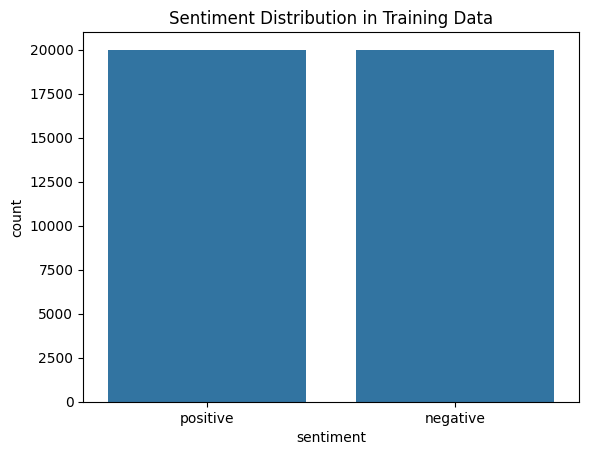

In [ ]:
# Explore class distribution
sns.countplot(x='sentiment', data=train_data)
plt.title('Sentiment Distribution in Training Data')
plt.show()


barplot for positive and negative implies that the response are distributed almost equally

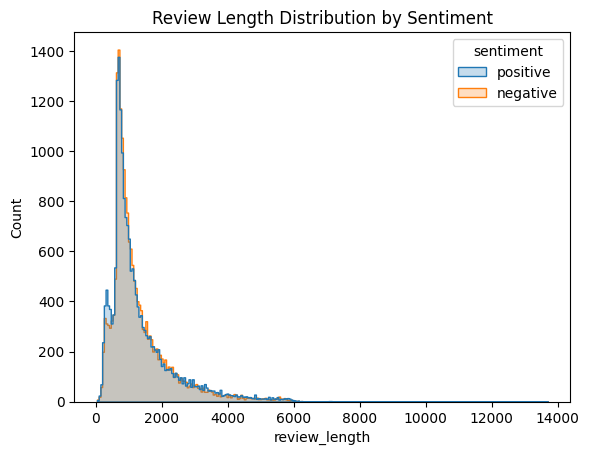

In [ ]:
# Review Length Analysis
train_data['review_length'] = train_data['review'].apply(len)
sns.histplot(x='review_length', data=train_data, hue='sentiment', element='step', common_norm=False)
plt.title('Review Length Distribution by Sentiment')
plt.show()

 plot shows the distribution of review lengths in the training data, with separate lines for each sentiment class. This visualization helps to understand if there are any patterns or differences in review lengths across different sentiment categories.

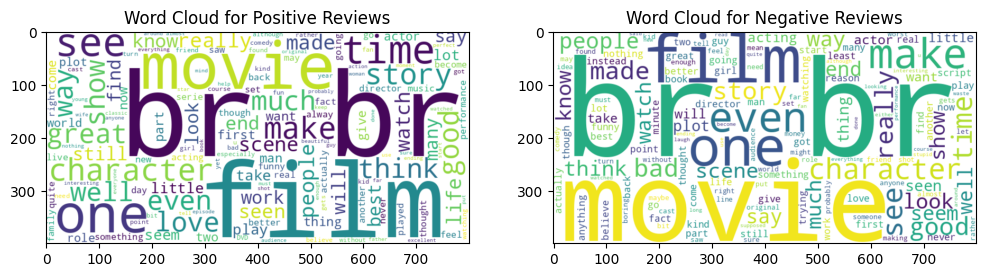

In [ ]:
# Word Frequency Analysis
from wordcloud import WordCloud

positive_reviews = train_data[train_data['sentiment'] == 'positive']['review']
negative_reviews = train_data[train_data['sentiment'] == 'negative']['review']


wordcloud_positive = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')

plt.show()

The  plot visually represents the most frequent words in positive and negative reviews, with larger words indicating higher frequency. This analysis helps in understanding the common themes or sentiments expressed in the reviews.

# Feature engineering

In [15]:
# Tokenization
train_data['tokenized_reviews'] = train_data['review'].apply(word_tokenize)
test_data['tokenized_reviews'] = test_data['review'].apply(word_tokenize)

# Stop-words Filtering
stop_words = set(stopwords.words('english'))

train_data['filtered_reviews'] = train_data['tokenized_reviews'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
test_data['filtered_reviews'] = test_data['tokenized_reviews'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])

Tokenization is the process of breaking down a text into individual words or tokens. In this step, the word_tokenize function from the NLTK library is applied to each review in the review column.
Stop-words are ubiquitous terms, such as "the," "is," and "and," that have little to no significance in a particular context.
The code uses set(stopwords.words('english')) to generate a set of English stop-words.

In [16]:
# Stemming vs. Lemmatization
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

train_data['stemmed_reviews'] = train_data['filtered_reviews'].apply(lambda tokens: [porter_stemmer.stem(word) for word in tokens])
train_data['lemmatized_reviews'] = train_data['filtered_reviews'].apply(lambda tokens: [wordnet_lemmatizer.lemmatize(word) for word in tokens])

test_data['stemmed_reviews'] = test_data['filtered_reviews'].apply(lambda tokens: [porter_stemmer.stem(word) for word in tokens])
test_data['lemmatized_reviews'] = test_data['filtered_reviews'].apply(lambda tokens: [wordnet_lemmatizer.lemmatize(word) for word in tokens])

 the application of stemming and lemmatization techniques to preprocess text data in the filtered_reviews column of both the training and test datasets.
Stemming is the process of reducing words to their root or base form, called the stem, by removing affixes.
Lemmatization is the process of reducing words to their base or dictionary form, called the lemma, while considering the word's context and part of speech.

In [6]:
# Vectorization - Count Vectorization
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(train_data['lemmatized_reviews'].apply(lambda tokens: ' '.join(tokens)))

In [19]:
# Vectorization - TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'].apply(lambda tokens: ' '.join(tokens)))

# Use the same vectorizer instance to transform the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'].apply(lambda tokens: ' '.join(tokens)))


TF-IDF vectorization on the lemmatized reviews in both the training and test datasets using the TfidfVectorizer
By using the same vectorizer instance for both training and test data, you ensure that the same vocabulary and IDF weights are applied consistently across both datasets, maintaining the integrity of the feature space and facilitating model evaluation and comparison.

In [8]:
# Comparison - Stemming vs. Lemmatization
print("Stemmed Review Example:")
print(train_data['stemmed_reviews'].iloc[0])

print("Stemmed Review Example:")
print(test_data['stemmed_reviews'].iloc[0])

print("\nLemmatized Review Example:")
print(train_data['lemmatized_reviews'].iloc[0])

print("\nLemmatized Review Example:")
print(test_data['lemmatized_reviews'].iloc[0])

Stemmed Review Example:
['caught', 'littl', 'gem', 'total', 'accid', 'back', '1980', "'81", '.', 'reviv', 'theatr', 'see', 'two', 'old', 'silli', 'sci-fi', 'movi', '.', 'theatr', 'pack', 'full', '(', 'warn', ')', 'show', 'bunch', 'sci-fi', 'short', 'spoof', '(', 'get', 'us', 'mood', ')', '.', 'somewhat', 'amus', 'came', ',', 'within', 'second', ',', 'audienc', 'hyster', '!', 'biggest', 'laugh', 'came', 'show', '``', 'princess', 'laia', "''", 'huge', 'cinnamon', 'bun', 'instead', 'hair', 'head', '.', 'look', 'camera', ',', 'give', 'grim', 'smile', 'nod', '.', 'made', 'even', 'funnier', '!', 'got', 'ta', 'see', '``', 'chewabacca', "''", 'play', 'look', 'like', 'muppet', '!', 'extrem', 'silli', 'stupid', '...', 'could', "n't", 'stop', 'laugh', '.', 'dialogu', 'drown', 'laughter', '.', 'also', 'know', '``', 'star', 'war', "''", 'pretti', 'well', "'s", 'even', 'funnier', '--', 'deliber', 'poke', 'fun', 'dialogu', '.', 'realli', 'work', 'audienc', '!', 'definit', '10', '!']

Lemmatized Revie

In [ ]:
# Comparison - Count Vectorization vs TF-IDF Vectorization
#print("\nCount Vectorization Example:")
#print(X_count.toarray()[0])  # Display the vectorized representation of the first review using Count Vectorization


Count Vectorization Example:


In [ ]:
print("\nTF-IDF Vectorization Example:")
print(X_train_tfidf.toarray()[0])  # Display the vectorized representation of the first review using TF-IDF Vectorization

# Modeling

In [20]:
# Split the data
y_test = test_data['sentiment']
y_train = train_data['sentiment']

# Baseline Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_tfidf, y_train)
logistic_predictions = logistic_model.predict(X_test_tfidf)

# Evaluate Logistic Regression Model
print("Logistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, logistic_predictions))
print("Classification Report:\n", classification_report(y_test, logistic_predictions))


Logistic Regression Model:
Accuracy: 0.8971
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.88      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Accuracy of Logistic Regression Model is 89.71%. The precision of positive, it's right about 89% of the time. For negative predictions, it's about 91% accurate. F1-score is about 0.90 for both positive and negative reviews.
Hence, our model is quite good at predicting whether a review is positive or negative. It's right most of the time and does a good job of finding positive and negative reviews.

In [21]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)

# Evaluate Naive Bayes Model
print("\nNaive Bayes Model:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:\n", classification_report(y_test, nb_predictions))


Naive Bayes Model:
Accuracy: 0.8663
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.88      0.87      5000
    positive       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Accuracy is about 0.8663. It predicts a sentiment: about 85% accurate for negative predictions and 88% accurate for positive predictions.
F1-score is 0.87. So, the Naive Bayes model is also quite good at predicting sentiment It's slightly less accurate than the logistic regression model, but it still performs well overall.

In [22]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest Model
print("\nRandom Forest Model:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))


Random Forest Model:
Accuracy: 0.8584
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.86      0.86      5000
    positive       0.86      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



the Random Forest model's accuracy is about 0.8584, it predicts a sentiment about 85% accurate for negative predictions and 86% accurate for positive predictions.
F1-score is about 0.86.
Hence, the Random Forest model also performs well, with an accuracy of 85.84%. It's slightly less accurate than the Naive Bayes and Logistic Regressionmodels, but still quite effective at predicting sentiment.

So I chose Logistic Regression model

I also used Naive Bayes models, one with stemming and the other with lemmatization

In [23]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Initialize Stemmer and Lemmatizer
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Apply Stemming
train_data['stemmed_reviews'] = train_data['filtered_reviews'].apply(lambda tokens: [porter_stemmer.stem(word) for word in tokens])
test_data['stemmed_reviews'] = test_data['filtered_reviews'].apply(lambda tokens: [porter_stemmer.stem(word) for word in tokens])

# Apply Lemmatization
train_data['lemmatized_reviews'] = train_data['filtered_reviews'].apply(lambda tokens: [wordnet_lemmatizer.lemmatize(word) for word in tokens])
test_data['lemmatized_reviews'] = test_data['filtered_reviews'].apply(lambda tokens: [wordnet_lemmatizer.lemmatize(word) for word in tokens])


# Vectorize using Count Vectorization or TF-IDF Vectorization
vectorizer = TfidfVectorizer()  # You can use CountVectorizer as well
X_train_vectorized = vectorizer.fit_transform(train_data['lemmatized_reviews'].apply(lambda tokens: ' '.join(tokens)))
X_test_vectorized = vectorizer.transform(test_data['lemmatized_reviews'].apply(lambda tokens: ' '.join(tokens)))

# Train Naive Bayes Model with Stemming or Lemmatization
nb_model_stemmed = MultinomialNB()
nb_model_stemmed.fit(X_train_vectorized, y_train)
nb_predictions_stemmed = nb_model_stemmed.predict(X_test_vectorized)

# Evaluate Naive Bayes Model with Stemming
print("\nNaive Bayes Model with Stemming:")
print("Accuracy:", accuracy_score(y_test, nb_predictions_stemmed))
print("Classification Report:\n", classification_report(y_test, nb_predictions_stemmed))

# Train Naive Bayes Model with Lemmatization
nb_model_lemmatized = MultinomialNB()
nb_model_lemmatized.fit(X_train_vectorized, y_train)
nb_predictions_lemmatized = nb_model_lemmatized.predict(X_test_vectorized)

# Evaluate Naive Bayes Model with Lemmatization
print("\nNaive Bayes Model with Lemmatization:")
print("Accuracy:", accuracy_score(y_test, nb_predictions_lemmatized))
print("Classification Report:\n", classification_report(y_test, nb_predictions_lemmatized))



Naive Bayes Model with Stemming:
Accuracy: 0.8663
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.88      0.87      5000
    positive       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Naive Bayes Model with Lemmatization:
Accuracy: 0.8663
Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.88      0.87      5000
    positive       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Both models achieve an accuracy of 0.8663.F1-score is approximately 0.87 for both models, indicating a good overall performance in terms of both precision and recall.
Overall, both Naive Bayes models perform similarly, whether stemming or lemmatization is applied. This suggests that the choice between stemming and lemmatization may not significantly impact the performance of the Naive Bayes model in this scenario.

In [24]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression Model with Stemming
logistic_model_stemmed = LogisticRegression()
logistic_model_stemmed.fit(X_train_vectorized, y_train)
logistic_predictions_stemmed = logistic_model_stemmed.predict(X_test_vectorized)

# Evaluate Logistic Regression Model with Stemming
print("\nLogistic Regression Model with Stemming:")
print("Accuracy:", accuracy_score(y_test, logistic_predictions_stemmed))
print("Classification Report:\n", classification_report(y_test, logistic_predictions_stemmed))

# Train Logistic Regression Model with Lemmatization
logistic_model_lemmatized = LogisticRegression()
logistic_model_lemmatized.fit(X_train_vectorized, y_train)
logistic_predictions_lemmatized = logistic_model_lemmatized.predict(X_test_vectorized)

# Evaluate Logistic Regression Model with Lemmatization
print("\nLogistic Regression Model with Lemmatization:")
print("Accuracy:", accuracy_score(y_test, logistic_predictions_lemmatized))
print("Classification Report:\n", classification_report(y_test, logistic_predictions_lemmatized))



Logistic Regression Model with Stemming:
Accuracy: 0.8971
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.88      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Logistic Regression Model with Lemmatization:
Accuracy: 0.8971
Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.88      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



Both Logistic Regression models, one with stemming and the other with lemmatization, have similar performance metrics:

Accuracy: Both models have an accuracy of 0.8971, which means they are correct about 89.71% of the time.

Precision: For both negative and positive classes, precision is about 91% and 89% respectively, indicating that the models are quite accurate in their predictions.

Recall: Both models have recall scores around 88% for the negative class and 91% for the positive class, meaning they can effectively identify most of the instances of each class.

F1-score: The F1-score, which balances precision and recall, is about 0.90 for both models, indicating a good balance between precision and recall.

Overall, both models perform equally well, regardless of whether stemming or lemmatization is used. This suggests that the choice between stemming and lemmatization may not significantly impact the performance of the Logistic Regression model in this context.